# Copying an ArcGIS StoryMap item to another organization

## Introduction

Esri provides two models for telling stories with maps: The [Classic Story Map](https://storymaps-classic.arcgis.com/en/) and the newer [ArcGIS StoryMap](https://www.esri.com/en-us/arcgis/products/arcgis-storymaps/overview). Each offers the infrastructure to utilize ArcGIS Platform items such as [`Web Maps`](https://developers.arcgis.com/documentation/core-concepts/web-maps/) combined with supporting resources like images, text and videos for impactful storytelling. To answer your next question, please see [What's the Difference?](https://storymaps.arcgis.com/stories/6d3aff3f321f4f14b2f4ee29873c891b).

The platform stores each model differently, which leads to this sample document. The ArcGIS API for Python [`clone_items()`](https://developers.arcgis.com/python/api-reference/arcgis.gis.toc.html#arcgis.gis.ContentManager.clone_items) function equips you with all you need to effectively transfer many [Item](https://developers.arcgis.com/python/api-reference/arcgis.gis.toc.html#item) types between organizations, regardless of the organization's deployment. The `ArcGIS StoryMap` item is an exception to that currently. While there are plans to update `clone_items()` to handle the modern architecture behind `ArcGIS StoryMaps`, the sample below details a procedure to use immediately to transfer these items between organizations.

Let's proceed.

## Import Libraries

In [1]:
import os
import uuid
import json
import shutil
import tempfile

from arcgis.gis import GIS
from arcgis import __version__

Assign a variable to store appropriate version values to differentiate beween each story model.

In [2]:
_version = [int(i) for i in __version__.split('.')]

## Define function to export all the Story Map's resources to a zip file

Given its novel architecture and resource storage, we'll define a function to return the supporting resources for the ArcGIS StoryMap model.

In [3]:
def export_resources(item, save_path=None, file_name=None):
    """Export's the data's resources as a zip file"""
    url = \
        f'{item._gis._portal.resturl}content/users/{item._user_id}/items/{item.itemid}/resources/export'
    if save_path is None:
        save_path = tempfile.gettempdir()
    if file_name is None:
        file_name = f"{uuid.uuid4().hex[:6]}.zip"
    params = {'f' : 'zip'}
    con = item._gis._portal.con
    resources = con.get(url, params=params,
                        out_folder=save_path,
                        file_name=file_name,
                        try_json=False)
    return resources

## Connect to the source and destination GIS organizations

In [4]:
gis = GIS(profile='your_online_profile', verify_cert=False)
dest_gis = GIS(profile="your_online_admin_profile", verify_cert=False)

## Step 1. Get the `ArcGIS StoryMap` and export its resources
Once we have the item, we can use the `_version` variable we created earlier to run the `export_resources()` function we wrote earlier for `ArcGIS StoryMaps`, or the item's `resources` instance to export the supporting resources for `Classic Story Maps`. In this instance, we'll run `export_resources()` since we're copying an `ArcGIS Story Map`. 

In [5]:
story_map_id = "358b83b5f776402fa726cfa316aa197c"

story_map = gis.content.get(story_map_id)
if _version <= [1,8,2]:
    resource = export_resources(item=story_map)
else:
    resource = story_map.resources.export()

<Item title:"The Surprising State of Africa’s Giraffes" type:StoryMap owner:StoryMaps>
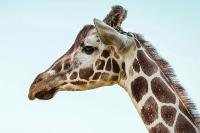

In [6]:
# Visualize the Story Map item details
story_map

Examine the resources used by the Story Map

In [7]:
resource

'C:\\Users\\computer_user\\AppData\\Local\\Temp\\aaa7dd.zip'

We can see the `resource` variable stores a path to a zip file containing all the supporting resources needed to reconstruct our original `ArcGIS StoryMap`.

## Step 2. Get the `StoryMap` Item's [data](https://developers.arcgis.com/rest/users-groups-and-items/item-data.htm) to extract maps

`ArcGIS StoryMaps` utilize `Web Maps` and/or [Express Maps](https://doc.arcgis.com/en/arcgis-storymaps/author-and-share/add-maps.htm#ESRI_SECTION1_C30D73392D964D51A8B606128A8A6E8F) to contextualize the story's geography and allow direct interation with its mapped data. We can use the [`get_data()`](https://developers.arcgis.com/python/api-reference/arcgis.gis.toc.html#arcgis.gis.Item.get_data) method to extract each from the `StoryMap`.

In [1]:
print(f"{'-'*80}")

--------------------------------------------------------------------------------


In [8]:
# Collect the Web Maps and Express Maps using the StoryMap's data. Use the set 
# operator each item is collected only once for cloning.
story_map_json = story_map.get_data(try_json=True)

web_maps = set([v['data']['itemId'] for k, v in story_map_json['resources'].items() \
                if v['type'].lower().find('webmap')>-1])
express_maps = set([v['data']['itemId'] for k, v in story_map_json['resources'].items() \
                    if v['type'].lower().find('expressmap')>-1])

Clone each `Web Map` from the `StoryMap` and assign a dictionary with the source `Web Map` id as the key, and the cloned `Web Map` id as the value. We'll use this dictionary to replace the source `Web Map` id with the cloned `Web Map` id in the new item we create in the destination GIS. 

Let's examine the Web Map(s) from the set we created above.

In [9]:
webmap_mapper = {}
for wm in web_maps:
    webmap_to_copy = gis.content.get(wm)
    cloned_webmaps = dest_gis.content.clone_items([webmap_to_copy]) # Clones the WebMap
    webmap_mapper[webmap_to_copy.id] = [i for i in cloned_webmaps if i.type == 'Web Map'][0].id

The `clone_items()` function used above duplicates not only the `Web Map`, but also any [`Layers`](https://doc.arcgis.com/en/arcgis-online/reference/layers.htm) contained in it. Depending upon the type of layer in the `Web Map`, cloning will create corresponding items in the destination.

Let's examine the cloned output and quickly compare the item details to the original `Web Map`.

In [10]:
cloned_webmaps

[<Item title:"Giraffe Species Ranges (IUCN)" type:Feature Layer Collection owner:webgis_user>,
 <Item title:"Giraffe Parks" type:Feature Layer Collection owner:webgis_user>,
 <Item title:"Giraffes" type:Web Map owner:webgis_user>]

<Item title:"Giraffes" type:Web Map owner:webgis_user>
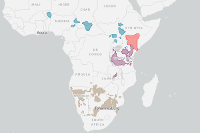

In [11]:
cloned_webmaps[2]

Let's also look at our dictionary and then use it to remap the original `Web Map` id to the cloned `Web Map` id in the json structure resulting from the `get_data()` function run earlier.

In [12]:
webmap_mapper

{'4a3c199b5375423e8a9b5c5e41dd709c': 'fcfee48147ae484080790eb5838c7253'}

Remap the OLD ItemId to the New Item ID

In [13]:
story_map_text = json.dumps(story_map_json)

for k, v in webmap_mapper.items():
    story_map_text = story_map_text.replace(k, v) # replace the IDs

## Step 3. Create a new StoryMap item in the Destination `GIS`

We'll use the original `story_map` variable properties to create a new `item` in our destination `GIS`. We'll eventually add the `resource` zip file we created earlier to the item to essetially duplicate the original `StoryMap`.

In [14]:
new_item = dest_gis.content.add({'type' : story_map.type,
                                 'tags' : story_map.tags,
                                 'title' : story_map.title,
                                 'description' : story_map.description,
                                 'typeKeywords' : story_map.typeKeywords,
                                 'extent' : story_map.extent,
                                 'text' :story_map_text}
                                )

In [15]:
new_item

<Item title:"The Surprising State of Africa’s Giraffes" type:StoryMap owner:webgis_user>

Let's also download the original `item` thumbnail to use to update our new `item'.

In [16]:
# orig_thumbnail = story_map.download_thumbnail(r"your/file/path")
orig_thumbnail = story_map.download_thumbnail(r"C:/Job/sftriage/thumbnails/")

In [17]:
new_item.update(thumbnail=orig_thumbnail)

True

<Item title:"The Surprising State of Africa’s Giraffes" type:StoryMap owner:webgis_user>
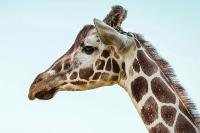

In [18]:
new_item

## Step 4. Add the `StoryMap` resources
We exported the images, expressmaps, text or other resources associated with the `StoryMap` earlier in this sample. Let's add those using the `resource` variable where we stored that output.

In [19]:
new_item.resources.add(resource,
                       archive=True)

{'success': True,
 'itemId': 'f17d68a0442f4657b2620d9f17d6542b',
 'owner': 'webgis_user',
 'folder': None}

## Step 5. Update the original `StoryMap` url
Set the `id` component of the new_`item`'s url to the new item `id` property. 

In [20]:
new_item.update({'url': story_map.url.replace(story_map.id, new_item.id)})

True

## Step 6. Transfer Draft Resources

`ArcGIS StoryMaps` support a workflow that enables you to make changes to a published story, preview those changes, and then republish to make those changes to the existing story. Such updates to published stories are stored as unpublished drafts and are not visible to the audience until you are ready to republish the story. 

The following code creates the supporting file to store draft resources and adds it as a supporting file to the destination `StoryMap`.

In [21]:
with tempfile.NamedTemporaryFile(mode='w', suffix='.json', 
                                 dir=tempfile.gettempdir(), 
                                 delete=False) as jsonfile:
    jsonfile.write(json.dumps(new_item.get_data()))
    new_item.resources.add(file=jsonfile.name)
    type_keywords = [tk for tk in new_item.typeKeywords if 'smdraftresourceid:' not in tk]
    type_keywords.append(f'smdraftresourceid:{os.path.basename(jsonfile.name)}')
    new_item.update({'typeKeywords' : type_keywords})

Draft express map resources are handled separately and added as a resource.

In [22]:
if len(express_maps) > 0:
    with tempfile.TemporaryDirectory() as d:
        shutil.unpack_archive(filename=resource, extract_dir=d)
        for expmap in express_maps:
            express_draft = os.path.join(d, "draft_"+ expmap)
            express_pub = os.path.join(d, "pub_" + expmap)
            if os.path.isfile(express_pub):
                shutil.copy(express_pub, express_draft)
                new_item.resources.add(express_draft)

## Use the new `StoryMap`!

In [23]:
print("your new item can be found here: " + new_item.homepage)

your new item can be found here: https://onlineshowcase.maps.arcgis.com/home/item.html?id=f17d68a0442f4657b2620d9f17d6542b


<Item title:"The Surprising State of Africa’s Giraffes" type:StoryMap owner:webgis_user>
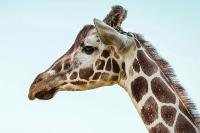

In [24]:
new_item